In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [2]:
from pathlib import Path
import torch
import time
import zarr
from pathlib import Path
import nibabel as nib
import numpy  as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
import midasmednet.dataset
from midasmednet.dataset import GridPatchSampler
from midasmednet.prediction import test_model
import logging

In [5]:
logging.basicConfig(level=logging.DEBUG)

### Grid sampler handling

In [379]:
zarr_path = '/mnt/share/raheppt1/data/aortath/interim/zarr/training_mra_preprocessed.zarr'
subject_keys = ['100000', '100001', '100002']
ds = GridPatchSampler(zarr_path,
                      subject_keys,
                      [100,100,100], [20,20,20],
                      image_group='images_norm',
                      out_channels=1)

patch_loader = DataLoader(ds, batch_size=4)

t = time.perf_counter()
for patch in patch_loader:
    print(patch['subject_key'][0], str(int(patch['count'][0])).zfill(6), patch['data'][0].shape)
    
    # process batch of patches ....
    
    # aggregate processed patches 
    ds.add_processed_batch(patch)
    
    new_t = time.perf_counter()
    print(f'{new_t - t: .3f}s')
    t = new_t

100000 000000 torch.Size([1, 100, 100, 100])
 1.432s
100000 000004 torch.Size([1, 100, 100, 100])
 0.035s
100000 000008 torch.Size([1, 100, 100, 100])
 0.036s
100000 000012 torch.Size([1, 100, 100, 100])
 0.081s
100000 000016 torch.Size([1, 100, 100, 100])
 0.053s
100000 000020 torch.Size([1, 100, 100, 100])
 0.029s
100000 000024 torch.Size([1, 100, 100, 100])
 0.019s
100000 000028 torch.Size([1, 100, 100, 100])
 0.018s
100000 000032 torch.Size([1, 100, 100, 100])
 0.016s
100000 000036 torch.Size([1, 100, 100, 100])
 0.019s
100000 000040 torch.Size([1, 100, 100, 100])
 0.024s
100000 000044 torch.Size([1, 100, 100, 100])
 0.020s
100000 000048 torch.Size([1, 100, 100, 100])
 0.014s
100000 000052 torch.Size([1, 100, 100, 100])
 0.019s
100000 000056 torch.Size([1, 100, 100, 100])
 0.014s
100001 000000 torch.Size([1, 100, 100, 100])
 0.477s
100001 000004 torch.Size([1, 100, 100, 100])
 0.050s
100001 000008 torch.Size([1, 100, 100, 100])
 0.016s
100001 000012 torch.Size([1, 100, 100, 100])
 

### Predicting segmentation masks

In [95]:
zarr_path = '/mnt/share/raheppt1/data/aortath/interim/zarr/training_mra_preprocessed.zarr'

#subject_keys = ['100099']
subject_key_file = '/mnt/share/raheppt1/data/aortath/interim/crossval/validation.dat'
with open(subject_key_file, 'r') as f:
        subject_keys = [key.strip() for key in f.readlines()]
        
model_path = '/mnt/share/raheppt1/data/aortath/processed/models/segm_first_model.pt'
results = test_model(input_data_path=zarr_path,
                input_group='images_norm',
                model_path=model_path,
                subject_keys=subject_keys,
                patch_size=[64,64,64], 
                patch_overlap=[10,10,10],
                batch_size=4,
                out_channels=2,
                in_channels=1,
                fmaps=64,
                num_workers=0,
                one_hot_encoded=False,
                data_reader=midasmednet.dataset.read_zarr)

INFO:midasmednet.prediction:using cuda:0
INFO:midasmednet.prediction:creating U-net model (inputs 1, outputs 2)
INFO:midasmednet.prediction:restoring model, epoch: 46
INFO:midasmednet.prediction:inference ...
DEBUG:midasmednet.dataset:loading images_norm/100080
DEBUG:midasmednet.dataset:loading images_norm/100081
DEBUG:midasmednet.dataset:loading images_norm/100082
DEBUG:midasmednet.dataset:loading images_norm/100083
DEBUG:midasmednet.dataset:loading images_norm/100084
DEBUG:midasmednet.dataset:loading images_norm/100085
DEBUG:midasmednet.dataset:loading images_norm/100086
DEBUG:midasmednet.dataset:loading images_norm/100087
DEBUG:midasmednet.dataset:loading images_norm/100088
DEBUG:midasmednet.dataset:loading images_norm/100089
DEBUG:midasmednet.dataset:loading images_norm/100090
DEBUG:midasmednet.dataset:loading images_norm/100091
DEBUG:midasmednet.dataset:loading images_norm/100092
DEBUG:midasmednet.dataset:loading images_norm/100093
DEBUG:midasmednet.dataset:loading images_norm/100

In [96]:
results['100099'].shape

(1, 250, 190, 170)

<IPython.core.display.Javascript object>


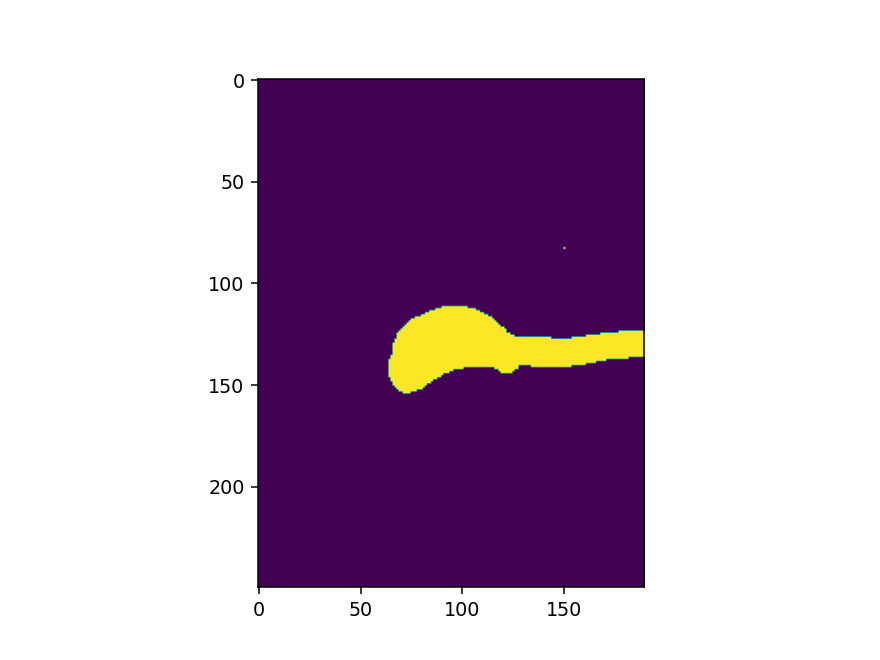

In [98]:
plt.figure()
plt.imshow(np.max(results['100099'][0,...].astype(np.float32), axis=2))

### Predicting landmarks

In [82]:
zarr_path = '/mnt/share/raheppt1/data/aortath/interim/zarr/training_mra_preprocessed.zarr'

#subject_keys = ['100098','100099']
subject_key_file = '/mnt/share/raheppt1/data/aortath/interim/crossval/validation.dat'
with open(subject_key_file, 'r') as f:
        subject_keys = [key.strip() for key in f.readlines()]
        
model_path = '/mnt/share/raheppt1/data/aortath/processed/models/test_run1_200409_212019_model.pt'
results = test_model(input_data_path=zarr_path,
                input_group='images_norm',
                model_path=model_path,
                subject_keys=subject_keys[:3],
                patch_size=[96,96,96], 
                patch_overlap=[5,5,5],
                batch_size=4,
                out_channels=6,
                in_channels=1,
                fmaps=64,
                num_workers=0,
                one_hot_encoded=True,
                softmax_output=False,
                data_reader=midasmednet.dataset.read_zarr)

INFO:midasmednet.prediction:using cuda:0
INFO:midasmednet.prediction:creating U-net model (inputs 1, outputs 6)
INFO:midasmednet.prediction:restoring model, epoch: 12
INFO:midasmednet.prediction:inference ...
DEBUG:midasmednet.dataset:loading images_norm/100080
DEBUG:midasmednet.dataset:loading images_norm/100081
DEBUG:midasmednet.dataset:loading images_norm/100082


In [87]:
results['100080'].dtype

dtype('float16')

<IPython.core.display.Javascript object>


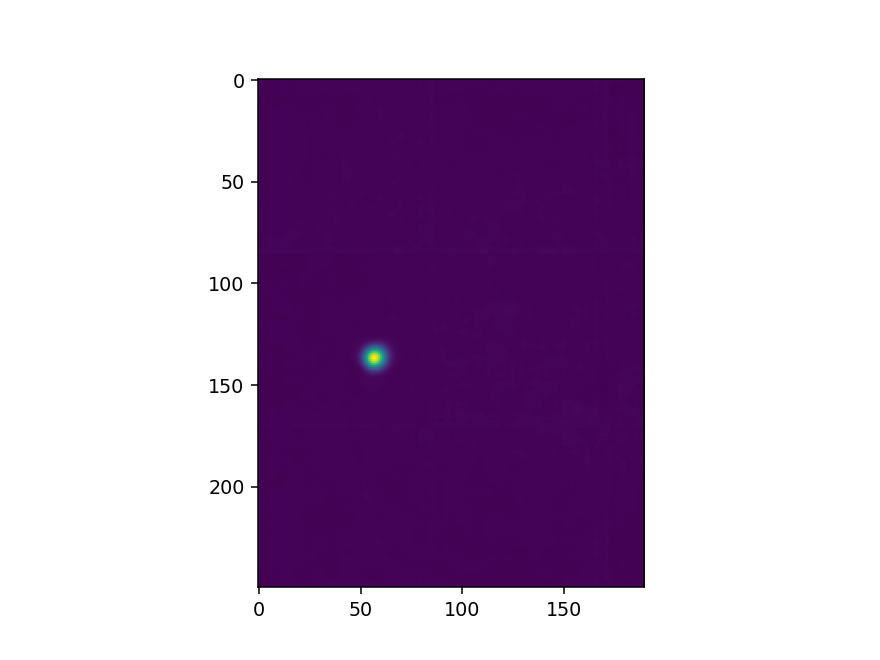

In [94]:
plt.figure()
plt.imshow(np.mean(results['100080'][1, ...].astype(np.float32), axis=2))

### Saving results to zarr

In [600]:
# write results to zarr file
zarr_path = '/mnt/share/raheppt1/data/aortath/processed/predictions/zarr/data_predictions.zarr'

with zarr.open(zarr_path, 'a') as zf:
    gr = zf.require_group('heatmap_predictions')
    for key in subject_keys:
        print(key)
        output = results[key].astype(np.float16)
        ds = gr.require_dataset(key, output.shape, dtype=output.dtype)
        ds[:] = output

100080
100081
100082
100083
100084
100085
100086
100087
100088
100089
100090
100091
100092
100093
100094
100095
100096
100097
100098
100099


In [521]:
# copy group from zarr to zarr
from sys import stdout
zarr_src_path = '/mnt/share/raheppt1/data/aortath/interim/zarr/data.zarr'
zarr_dest_path = '/mnt/share/raheppt1/data/aortath/interim/zarr/data_predictions.zarr'
with zarr.open(zarr_src_path, 'r') as source:
    with zarr.open(zarr_dest_path, 'a') as destination:
        zarr.copy(source['affines'], destination, log=stdout)

copy /affines
copy /affines/100000 (4, 4) float64
copy /affines/100001 (4, 4) float64
copy /affines/100002 (4, 4) float64
copy /affines/100003 (4, 4) float64
copy /affines/100004 (4, 4) float64
copy /affines/100005 (4, 4) float64
copy /affines/100006 (4, 4) float64
copy /affines/100007 (4, 4) float64
copy /affines/100008 (4, 4) float64
copy /affines/100009 (4, 4) float64
copy /affines/100010 (4, 4) float64
copy /affines/100011 (4, 4) float64
copy /affines/100012 (4, 4) float64
copy /affines/100013 (4, 4) float64
copy /affines/100014 (4, 4) float64
copy /affines/100015 (4, 4) float64
copy /affines/100016 (4, 4) float64
copy /affines/100017 (4, 4) float64
copy /affines/100018 (4, 4) float64
copy /affines/100019 (4, 4) float64
copy /affines/100020 (4, 4) float64
copy /affines/100021 (4, 4) float64
copy /affines/100022 (4, 4) float64
copy /affines/100023 (4, 4) float64
copy /affines/100024 (4, 4) float64
copy /affines/100025 (4, 4) float64
copy /affines/100026 (4, 4) float64
copy /affines/

In [601]:
# export zarr dataset to nifti
zarr_path = '/mnt/share/raheppt1/data/aortath/interim/zarr/data_predictions.zarr'
out_dir = '/mnt/share/raheppt1/data/aortath/processed/predictions/nifti'
group = 'heatmap_predictions'

with zarr.open(zarr_path, 'r') as zf:
    for key in subject_keys:
        print(key)
        affine = zf[f'affines/{key}']
        data = zf[f'{group}/{key}']
        channels = data.shape[0]
        for c in range(channels):
            channel_data = data[c,...]
            img = nib.Nifti1Image(channel_data, affine)
            save_path = Path(out_dir).joinpath(f'{key}_{group}_{c}.nii.gz')
            nib.save(img, save_path)
            print(channel_data.dtype)

100080
uint8
uint8
uint8
uint8
uint8
uint8
100081
uint8
uint8
uint8
uint8
uint8
uint8
100082
uint8
uint8
uint8
uint8
uint8
uint8
100083
uint8
uint8
uint8
uint8
uint8
uint8
100084
uint8
uint8
uint8
uint8
uint8
uint8
100085
uint8
uint8
uint8
uint8
uint8
uint8
100086
uint8
uint8
uint8
uint8
uint8
uint8
100087
uint8
uint8
uint8
uint8
uint8
uint8
100088
uint8
uint8
uint8
uint8
uint8
uint8
100089
uint8
uint8
uint8
uint8
uint8
uint8
100090
uint8
uint8
uint8
uint8
uint8
uint8
100091
uint8
uint8
uint8
uint8
uint8
uint8
100092
uint8
uint8
uint8
uint8
uint8
uint8
100093
uint8
uint8
uint8
uint8
uint8
uint8
100094
uint8
uint8
uint8
uint8
uint8
uint8
100095
uint8
uint8
uint8
uint8
uint8
uint8
100096
uint8
uint8
uint8
uint8
uint8
uint8
100097
uint8
uint8
uint8
uint8
uint8
uint8
100098
uint8
uint8
uint8
uint8
uint8
uint8
100099
uint8
uint8
uint8
uint8
uint8
uint8


In [7]:
zarr_path = '/mnt/share/raheppt1/data/all_mra_preprocessed.zarr'
out_dir = '/mnt/share/raheppt1/data/aortath/processed/'
group = 'images_norm'

with zarr.open(zarr_path, 'r') as zf:
    for key in zf[group]:
        print(key)
        affine = zf[f'affines/{key}']
        data = zf[f'{group}/{key}']
        channels = data.shape[0]
        for c in range(channels):
            channel_data = data[c,...].astype(np.float32)
            img = nib.Nifti1Image(channel_data, affine)
            save_path = Path(out_dir).joinpath(f'{key}_{group}_{c}.nii.gz')
            nib.save(img, save_path)
            print(channel_data.dtype)

100000
float32
100001
float32
100002
float32
100003
float32
100004
float32
100005
float32
100006
float32
100007
float32
100008
float32
100009
float32
